# Example of Calibration

Import stuff

In [1]:
# Default

budget = 8192
num_workers = 256
maximum_jobs = 64

In [2]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dask.distributed import Client
from dask_jobqueue import SLURMCluster as Cluster

import nevergrad as ng
from mhpc_project.matsch_b2 import CalibrationModel, Variables, Loss, NGO
from geotopy.utils import date_parser, comparison_plot, ProgressBar, ParametersLogger
from geotopy.measures import KGE

Load observations and apply some filters

In [4]:
observations = pd.read_csv('../data/Matsch B2/observations/obs.csv',
                           na_values=['-9999', '-99.99'],
                           usecols=[0, 2],
                           parse_dates=[0],
                           date_parser=date_parser,
                           index_col=0,
                           squeeze=True)
observations.index.rename('datetime', inplace=True)

selection = observations.index.map(lambda x: not (x < date_parser('01/03/2011 23:00') or x.month in [12,1,2]))

observations = observations[selection]

Load observations, model, loss function and calibration strategy

In [5]:
model = CalibrationModel('../data/Matsch B2/geotop', run_args={'timeout': 180})
variables = Variables('../data/Matsch B2/variables/testbed.csv')
measure = KGE(observations)
loss = Loss(model, variables, measure)
calibration = NGO(loss, budget=budget, num_workers=num_workers)

Evaluate the model and plot the risults

Before optimization loss is 0.7071019548837151


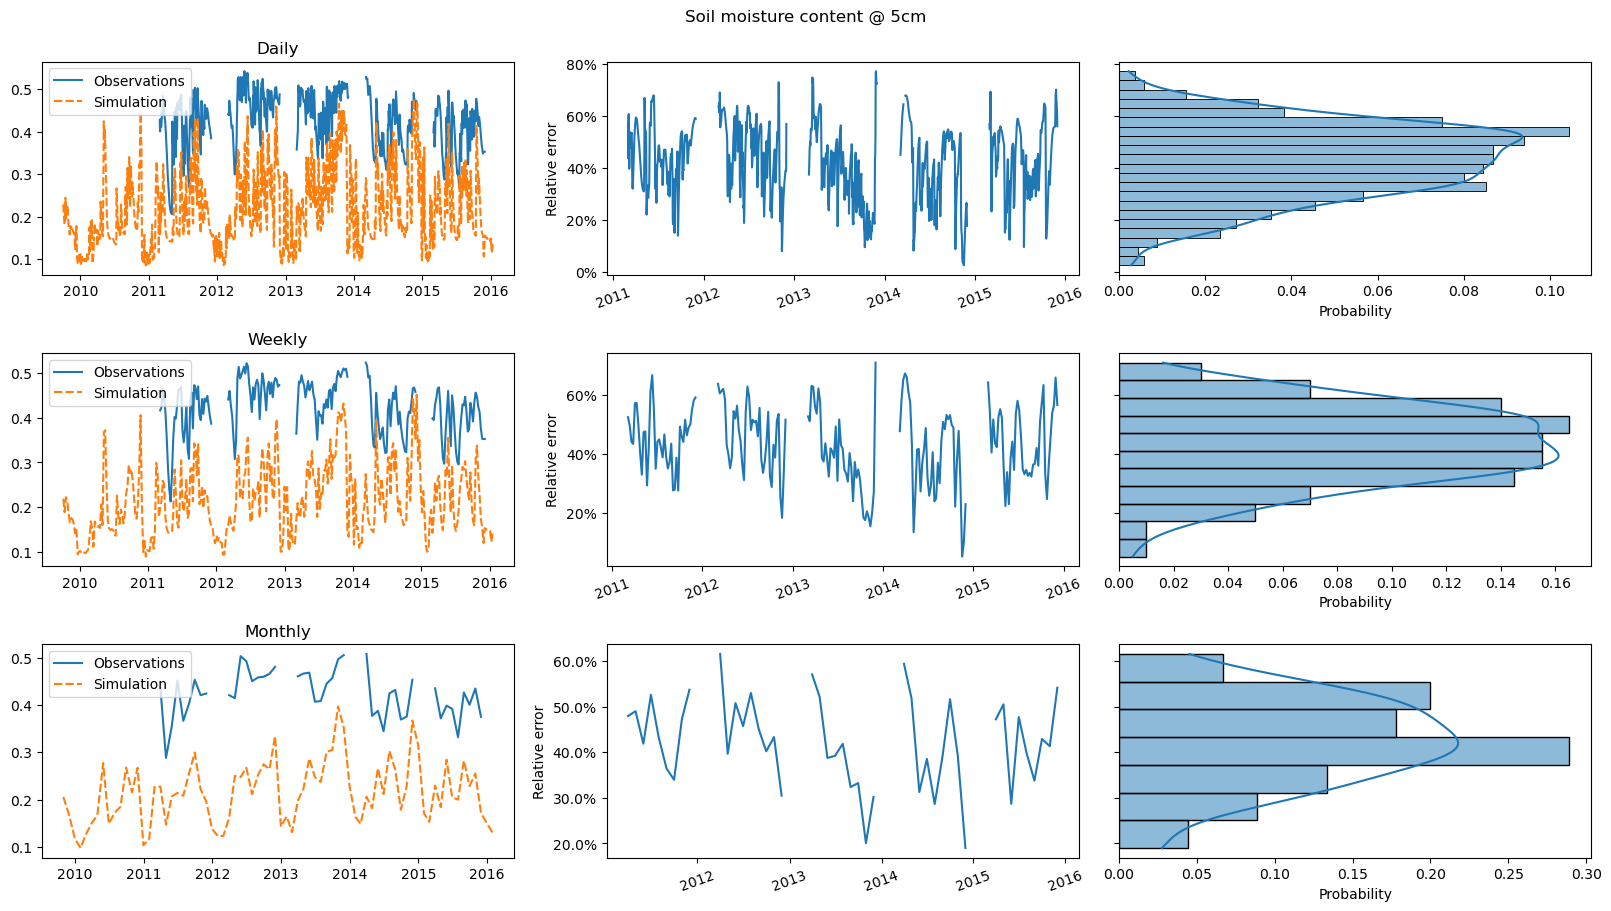

In [6]:
simulation = model()
print(f"Before optimization loss is {measure(simulation)}")
comparison_plot(observations,
                simulation,
                desc='Soil moisture content @ 5cm',
                rel=True)
plt.show()

Launch Dask cluster using `dask-jobqueue`

In [7]:
cluster = Cluster()
cluster.adapt(maximum_jobs=maximum_jobs)

client = Client(cluster)

Run calibration

In [8]:
logger = ParametersLogger(loss.massage)

calibration.optimizer.register_callback('tell', logger)

calibration.optimizer.register_callback('tell', ProgressBar(total=calibration.optimizer.budget))

with warnings.catch_warnings():
    
    warnings.simplefilter("ignore")
    recommendation = calibration(executor=client)

(128_w,256)-aCMA-ES (mu_w=66.9,w_1=3%) in dimension 10 (seed=<module 'time' (built-in)>, Fri Nov 27 19:23:25 2020)


Plot results and show table of calibrated values

After optimization loss is 0.2401898050231394


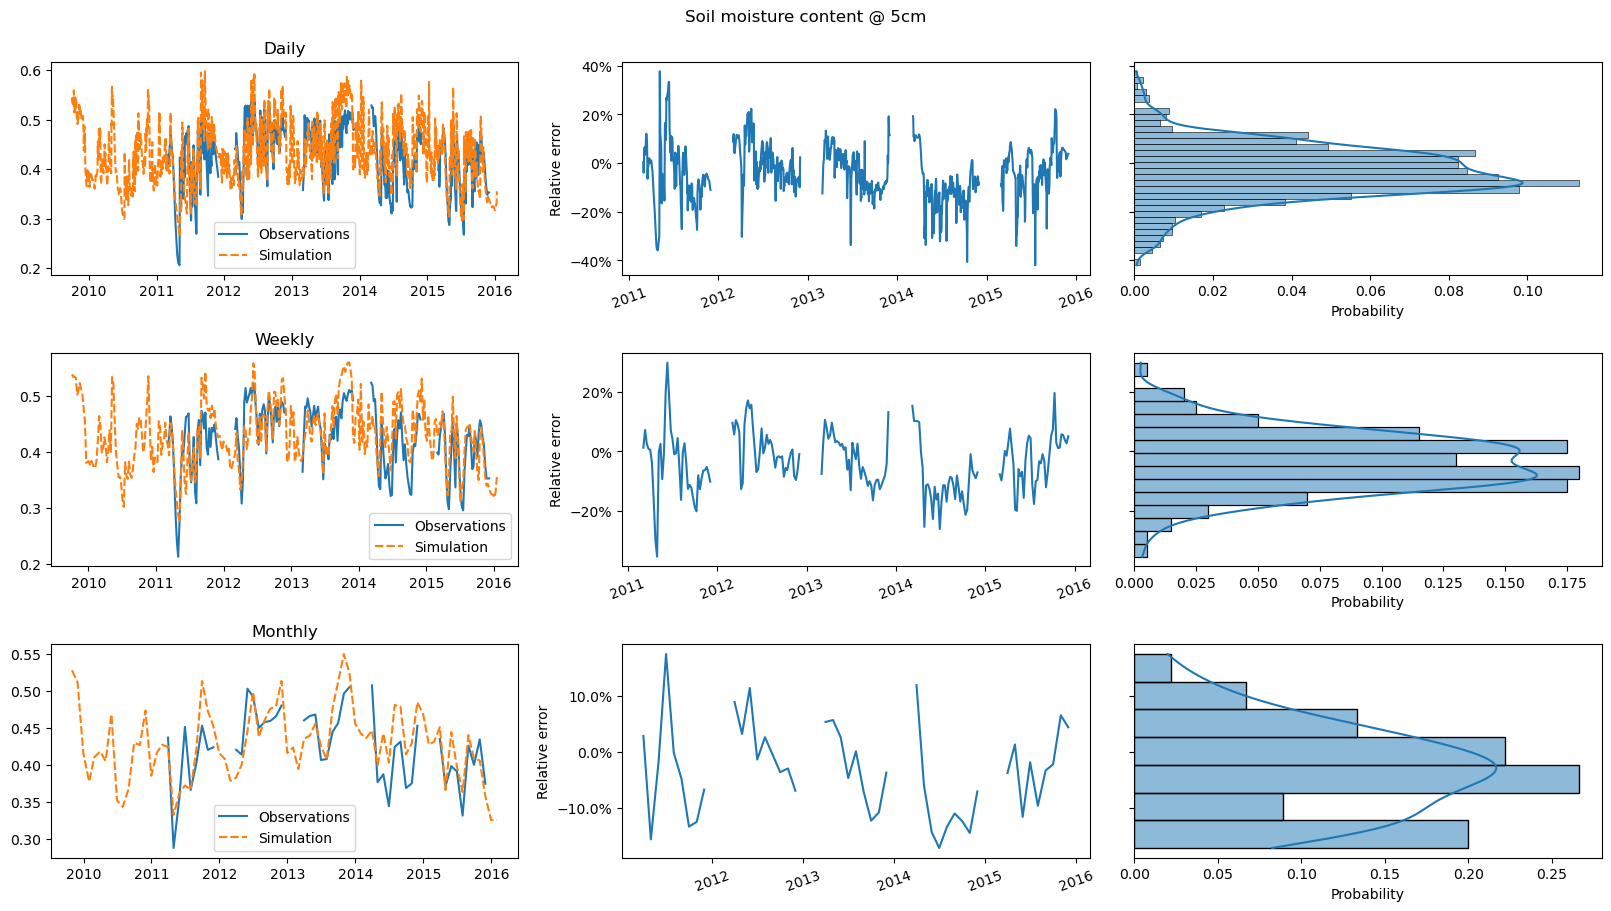

In [9]:
simulation = model(**recommendation)
print(f"After optimization loss is {measure(simulation)}")
comparison_plot(observations,
                simulation,
                desc='Soil moisture content @ 5cm',
                rel=True)
plt.show()

In [10]:
calibration.to_dataframe(recommendation)

lower   upper  recommendation
NormalHydrConductivity  0.00001     1.0        0.013477
ThetaRes                0.00000     1.0        0.189842
WiltingPoint            0.00000     1.0        0.013288
FieldCapacity           0.00000     1.0        0.607932
ThetaSat                0.00000     1.0        0.647526
NVanGenuchten           1.01000     2.5        1.147011
AlphaVanGenuchten       0.00001     1.0        0.000860
LSAI                    0.00000     5.0        1.042750
RootDepth               0.00000  1500.0      368.257241
SoilRoughness           0.10000   100.0        0.718859

In [11]:
logger.parallel_coordinate_plot()

<IPython.core.display.Javascript object>

In [34]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook

In [36]:
output_notebook()

Loading BokehJS ...

In [74]:
p = figure(x_axis_type='datetime', tools='xpan, xwheel_zoom', active_scroll='xwheel_zoom')
p.line(observations.index.to_numpy(), observations.to_numpy(), line_color='blue', line_width=2, legend_label='observations')
p.line(simulation.index.to_numpy(), simulation.to_numpy(), line_color='red', line_width=2, legend_label='simulation')
show(p)